# DAPA Tutorial #3: Timeseries - Sentinel-2

## Load environment variables
Please make sure that the environment variable "DAPA_URL" is set in the `custom.env` file. You can check this by executing the following block. 

If DAPA_URL is not set, please create a text file named `custom.env` in your home directory with the following input: 
>DAPA_URL=YOUR-PERSONAL-DAPA-APP-URL

In [1]:
from edc import setup_environment_variables
setup_environment_variables()

API credentials have automatically been injected for your active subscriptions.  
The following environment variables are now available:

The following additional environment variables have been loaded from `~/custom.env`:
* `AWS_BUCKET`
* `DAPA_URL`
* `DB_HOST`, `DB_NAME`, `DB_PASSWORD`, `DB_USER`
* `OGC_EDC_URL`
* `REFERENCE_DATA`


## Check notebook compabtibility
**Please note:** If you conduct this notebook again at a later time, the base image of this Jupyter Hub service can include newer versions of the libraries installed. Thus, the notebook execution can fail. This compatibility check is only necessary when something is broken. 

In [2]:
from edc import check_compatibility
check_compatibility("user-0.24.5", dependencies=[])

## Load libraries
Python libraries used in this tutorial will be loaded.

In [3]:
import os
import xarray as xr
import pandas as pd
import requests
import matplotlib
from ipyleaflet import Map, Rectangle, Marker, DrawControl, basemaps, basemap_to_tiles
%matplotlib inline

## Set DAPA endpoint
Execute the following code to check if the DAPA_URL is available in the environment variable and to set the `/dapa` endpoint. 

In [4]:
service_url = None
dapa_url = None

if 'DAPA_URL' not in os.environ:
    print('!! DAPA_URL does not exist as environment variable. Please make sure this is the case - see first block of this notebook! !!')
else:    
    service_url = os.environ['DAPA_URL']
    dapa_url = '{}/{}'.format(service_url, 'oapi')
    print('DAPA path: {}'.format(dapa_url.replace(service_url, '')))

DAPA path: /oapi


## Get collections supported by this endpoint
This request provides a list of collections. The path of each collection is used as starting path of this service.

In [5]:
collections_url = '{}/{}'.format(dapa_url, 'collections')
collections = requests.get(collections_url, headers={'Accept': 'application/json'})

print('DAPA path: {}'.format(collections.url.replace(service_url, '')))
collections.json()

DAPA path: /oapi/collections


['/oapi/collections/DEM/',
 '/oapi/collections/L8L1C/',
 '/oapi/collections/S1GRD/',
 '/oapi/collections/S2L1C/',
 '/oapi/collections/S2L2A/',
 '/oapi/collections/S3OLCI/',
 '/oapi/collections/S3SLSTR/',
 '/oapi/collections/S5PL2/',
 '/oapi/collections/MODIS/']

## Get fields of collection Sentinel-2 L2A
The fields (or variables in other DAPA endpoints - these are the bands of the raster data) can be retrieved in all requests to the DAPA endpoint. In addition to the fixed set of fields, "virtual" fields can be used to conduct math operations (e.g., the calculation of indices). 

In [6]:
collection = 'S2L2A'

fields_url = '{}/{}/{}/{}'.format(dapa_url, 'collections', collection, 'dapa/fields')
fields = requests.get(fields_url, headers={'Accept': 'application/json'})

print('DAPA path: {}'.format(fields.url.replace(service_url, '')))
fields.json()

DAPA path: /oapi/collections/S2L2A/dapa/fields


[{'id': 'B01', 'wavelength': 442.7},
 {'id': 'B02', 'wavelength': 492.4},
 {'id': 'B03', 'wavelength': 559.8},
 {'id': 'B04', 'wavelength': 664.6},
 {'id': 'B05', 'wavelength': 704.1},
 {'id': 'B06', 'wavelength': 740.5},
 {'id': 'B07', 'wavelength': 782.8},
 {'id': 'B08', 'wavelength': 832.8},
 {'id': 'B8A', 'wavelength': 864.7},
 {'id': 'B09', 'wavelength': 945.1},
 {'id': 'B11', 'wavelength': 1613.7},
 {'id': 'B12', 'wavelength': 2202.4},
 {'id': 'SCL', 'wavelength': None},
 {'id': 'SNW', 'wavelength': None},
 {'id': 'CLD', 'wavelength': None}]

## Retrieve NDVI as 1d time-series extraced for a single point

### Set DAPA URL and parameters
The output of this request is a time-series requested from a point of interest (`timeseries/position` endpoint). As the input collection (S2L2A) is a multi-temporal raster and the requested geometry is a point, no aggregation is conducted.

To retrieve a time-series of a point, the parameter `point` needs to be provided. The `time` parameter allows to extract data only within a specific time span. The band (`field`) from which the point is being extracted needs to be specified as well.

In [7]:
# DAPA URL
url = '{}/{}/{}/{}'.format(dapa_url, 'collections', collection, 'dapa/timeseries/position')

# Parameters for this request
params = {
    'point': '11.49,48.05',
    'time': '2018-04-01T00:00:00Z/2018-05-01T00:00:00Z',
    'fields': 'NDVI=(B08-B04)/(B08%2BB04)'    # Please note: + signs need to be URL encoded -> %2B
}

# show point in the map
location = list(reversed([float(coord) for coord in params['point'].split(',')]))
m = Map(
    basemap=basemap_to_tiles(basemaps.OpenStreetMap.Mapnik),
    center=location,
    zoom=10
)

marker = Marker(location=location, draggable=False)
m.add_layer(marker)

m

Map(center=[48.05, 11.49], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_o…

### Build request URL and conduct request

In [8]:
params_str = "&".join("%s=%s" % (k, v) for k,v in params.items())
r = requests.get(url, params=params_str)

print('DAPA path: {}'.format(r.url.replace(service_url, '')))
print('Status code: {}'.format(r.status_code))

DAPA path: /oapi/collections/S2L2A/dapa/timeseries/position?point=11.49,48.05&time=2018-04-01T00:00:00Z/2018-05-01T00:00:00Z&fields=NDVI=(B08-B04)/(B08%2BB04)
Status code: 200


### Write timeseries dataset to CSV file
The response of this request returns data as CSV including headers splitted by comma. Additional output formats (e.g., CSV with headers included) will be integrated within the testbed activtiy. 

You can either write the response to file or use it as string (`r.content` variable). 

In [9]:
# write time-series data to CSV file
with open('timeseries_s2.csv', 'wb') as filew:
    filew.write(r.content)

### Open timeseries dataset with pandas
Time-series data can be opened, processed, and plotted easily with the `Pandas` library. You only need to specify the `datetime` column to automatically convert dates from string to a datetime object. 

In [10]:
# read data into Pandas dataframe
ds = pd.read_csv('timeseries_s2.csv', parse_dates=['datetime'])

# set index to datetime column
ds.set_index('datetime', inplace=True)

# show dataframe
ds

,NDVI
datetime,
2018-04-02 10:24:35+00:00,0.701217
2018-04-04 10:10:21+00:00,0.229457
2018-04-07 10:20:20+00:00,0.833333
2018-04-09 10:13:43+00:00,0.634615
2018-04-12 10:20:24+00:00,0.100667
2018-04-14 10:15:36+00:00,0.509171
2018-04-17 10:20:21+00:00,0.497207
2018-04-19 10:14:57+00:00,0.686788
2018-04-22 10:21:15+00:00,0.671642


### Plot NDVI data

<AxesSubplot:xlabel='datetime'>

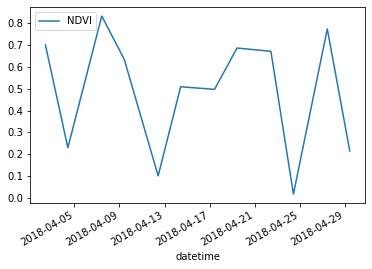

In [11]:
ds.plot()

### Output CSV file

In [12]:
!cat timeseries_s2.csv

## Time-series aggregated over area

In [13]:
# DAPA URL
url = '{}/{}/{}/{}'.format(dapa_url, 'collections', collection, 'dapa/timeseries/area')

# Parameters for this request
params = {
    #'point': '11.49,48.05',
    'bbox': '11.49,48.05,11.66,48.22',
    'aggregate': 'min,max,avg',
    'time': '2018-04-01T00:00:00Z/2018-05-01T00:00:00Z',
    'fields': 'NDVI=(B08-B04)/(B08%2BB04)'    # Please note: + signs need to be URL encoded -> %2B
}

params_str = "&".join("%s=%s" % (k, v) for k,v in params.items())
r = requests.get(url, params=params_str)

print('DAPA path: {}'.format(r.url.replace(service_url, '')))
print('Status code: {}'.format(r.status_code))

DAPA path: /oapi/collections/S2L2A/dapa/timeseries/area?bbox=11.49,48.05,11.66,48.22&aggregate=min,max,avg&time=2018-04-01T00:00:00Z/2018-05-01T00:00:00Z&fields=NDVI=(B08-B04)/(B08%2BB04)
Status code: 200


In [14]:
# read data into Pandas dataframe
from io import StringIO
ds = pd.read_csv(StringIO(r.text), parse_dates=['datetime'])

# set index to datetime column
ds.set_index('datetime', inplace=True)

# show dataframe
ds

,NDVI_min,NDVI_max,NDVI_avg
datetime,,,
2018-04-02 10:24:35+00:00,-1.000000,1.000000,0.351652
2018-04-04 10:10:21+00:00,-0.089418,0.601969,0.146855
2018-04-07 10:20:20+00:00,-1.000000,1.000000,0.366545
2018-04-09 10:13:43+00:00,-0.236350,0.874247,0.190702
2018-04-12 10:20:24+00:00,-0.086605,0.435908,0.096532
2018-04-14 10:15:36+00:00,-0.210497,0.798558,0.313741
2018-04-17 10:20:21+00:00,-0.565506,0.914530,0.217762
2018-04-19 10:14:57+00:00,-1.000000,1.000000,0.428746
2018-04-22 10:21:15+00:00,-1.000000,1.000000,0.459265


<AxesSubplot:xlabel='datetime'>

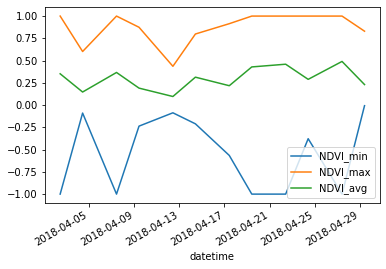

In [15]:
ds.plot()